In [1]:
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv("C:/Users/dario/OneDrive/Escritorio/Data sets/base_microdatos.csv")
df.head()

,indice_tiempo,clasificacion_vuelo,clase_vuelo,aerolinea,origen_oaci,origen_aeropuerto,origen_localidad,origen_provincia,origen_pais,origen_continente,destino_oaci,destino_aeropuerto,destino_localidad,destino_provincia,destino_pais,destino_continente,pasajeros,asientos,vuelos
0,2017-01-01,Cabotaje,No Regular,Andes Líneas Aéreas,SAAV,Aeropuerto de Sauce Viejo,Santa Fe,Santa Fe,Argentina,América del Sur,SAZS,Aeropuerto Int. Tte. Luis Candelaria,San Carlos de Bariloche,Río Negro,Argentina,América del Sur,85,85,1
1,2017-01-01,Cabotaje,No Regular,Andes Líneas Aéreas,SASA,Aeropuerto Int. Martín Miguel de Güemes,Salta,Salta,Argentina,América del Sur,SASJ,Aeropuerto Int. Gdor. Horacio Guzmán,San Salvador de Jujuy,Jujuy,Argentina,América del Sur,23,83,1
2,2017-01-01,Cabotaje,No Regular,Andes Líneas Aéreas,SAZS,Aeropuerto Int. Tte. Luis Candelaria,San Carlos de Bariloche,Río Negro,Argentina,América del Sur,SAAV,Aeropuerto de Sauce Viejo,Santa Fe,Santa Fe,Argentina,América del Sur,78,83,1
3,2017-01-01,Cabotaje,Regular,Aerolíneas Argentinas,SAAR,Aeropuerto Int. de Rosario Islas Malvinas,Rosario,Santa Fe,Argentina,América del Sur,SACO,Aeropuerto Int. Ingeniero Ambrosio Taravella,Córdoba,Córdoba,Argentina,América del Sur,48,128,1
4,2017-01-01,Cabotaje,Regular,Aerolíneas Argentinas,SAAR,Aeropuerto Int. de Rosario Islas Malvinas,Rosario,Santa Fe,Argentina,América del Sur,SAEZ,Aeropuerto Int. Ministro Pistarini,Ezeiza,Buenos Aires,Argentina,América del Sur,90,128,1


In [4]:
#Nos aseguramos que las fechas realmente estan en formato fecha
df["indice_tiempo"]=pd.to_datetime(df["indice_tiempo"])

In [5]:
#Filtramos para trabajar solo con predicciones de Buenos Aires
df_filtrado = df[df["origen_provincia"] == "Buenos Aires"]

In [7]:
#Agregamos nivel mensual
monthly = ( 
    df.set_index('indice_tiempo') 
    .resample('MS') # Month Start 
    .agg({'pasajeros': 'sum', 'vuelos': 'sum', 'asientos': 'sum'}) 
    .reset_index() )
           

In [8]:
#Ordenamos
monthly = monthly.sort_values('indice_tiempo')

In [10]:
# Lags (capturan inercia temporal) 
for lag in [1, 2, 3, 6, 12]: 
    monthly[f'pasajeros_lag_{lag}'] = monthly['pasajeros'].shift(lag) 
    
# Ventanas móviles (suavizan estacionalidad) 
for win in [3, 6, 12]: 
    monthly[f'pasajeros_ma_{win}'] = monthly['pasajeros'].rolling(win).mean() 
    monthly[f'vuelos_ma_{win}'] = monthly['vuelos'].rolling(win).mean() 
    monthly[f'asientos_ma_{win}'] = monthly['asientos'].rolling(win).mean() 
    
# Señales de calendario: mes y año 
monthly['mes'] = monthly['indice_tiempo'].dt.month 
monthly['anio'] = monthly['indice_tiempo'].dt.year 

# Drop de filas con NaN generados por lags/rolling 
monthly_model = monthly.dropna().copy()

In [13]:
# Usamos 80% para train, 20% para test, sin mezclar el orden temporal
split_idx = int(len(monthly_model) * 0.8)
train = monthly_model.iloc[:split_idx]
test = monthly_model.iloc[split_idx:]

features = [c for c in monthly_model.columns if c not in ['fecha','indice_tiempo','pasajeros']] 
X_train, y_train = train[features], train['pasajeros'] 
X_test, y_test = test[features], test['pasajeros']



In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test)).mean() * 100

print(f"MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | MAPE: {mape:.2f}%")


MAE: 125,057 | RMSE: 23,266,066,432 | MAPE: 4.66%


c:\Users\dario\anaconda3\envs\jupyter_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


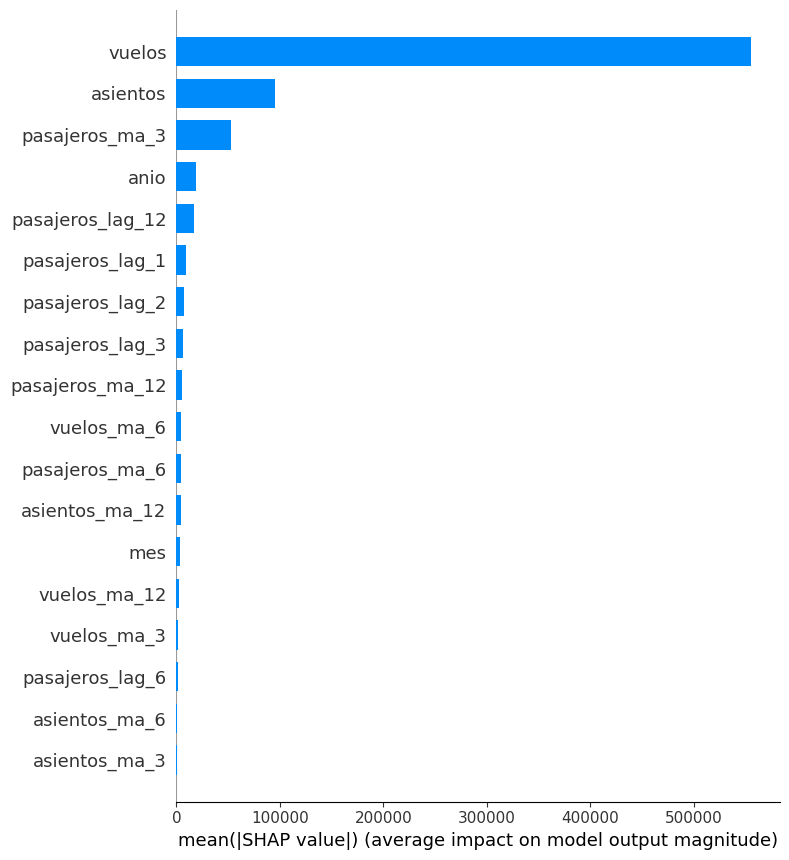

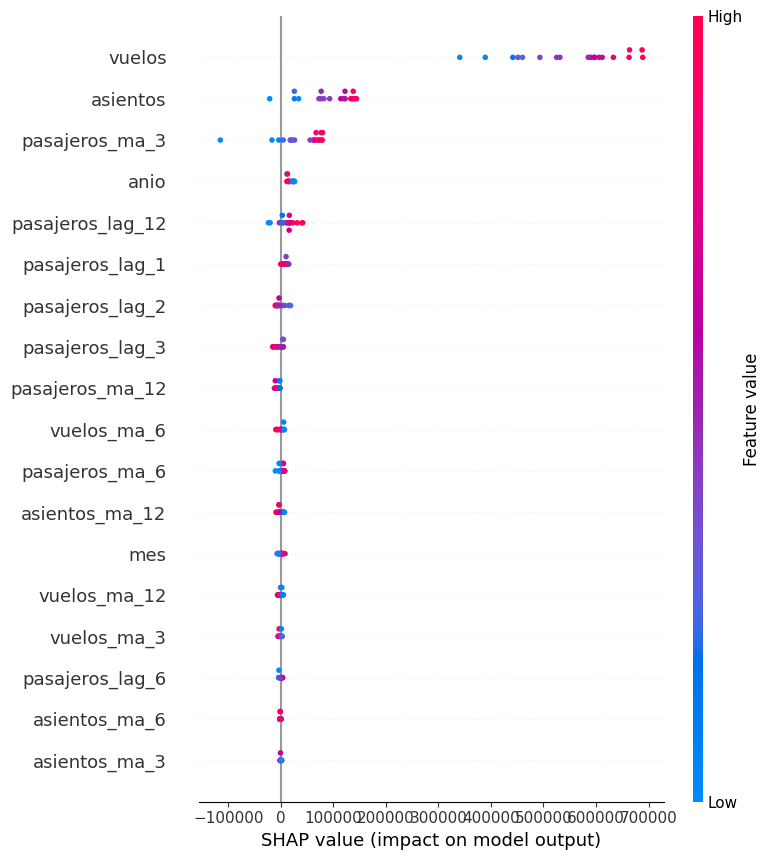

In [16]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Importancia global
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Distribución por feature
shap.summary_plot(shap_values, X_test)


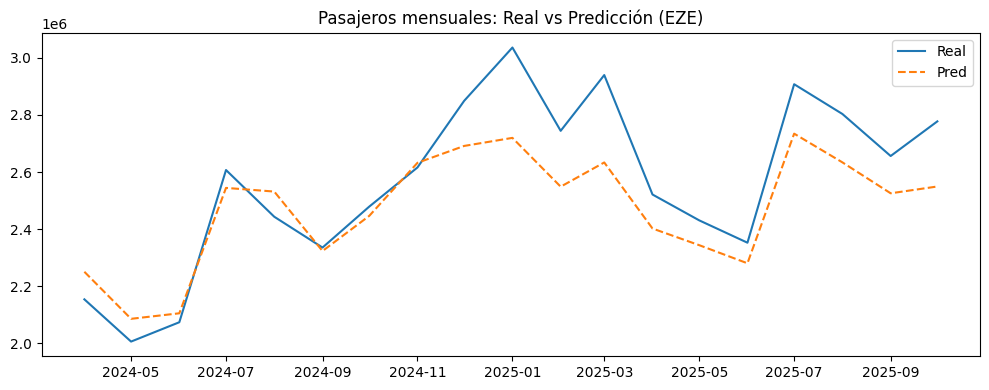

In [18]:
import matplotlib.pyplot as plt

# Serie real vs predicha en test
plot_df = test[['indice_tiempo', 'pasajeros']].copy()
plot_df['pred'] = y_pred

plt.figure(figsize=(10,4))
plt.plot(plot_df['indice_tiempo'], plot_df['pasajeros'], label='Real')
plt.plot(plot_df['indice_tiempo'], plot_df['pred'], label='Pred', linestyle='--')
plt.title('Pasajeros mensuales: Real vs Predicción (EZE)')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Serie temporal: pasajeros mensuales
serie = monthly.set_index('indice_tiempo')['pasajeros']
serie = serie.asfreq('MS')


# Entrenar modelo SARIMA
model = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

# Predicción a futuro (6 meses)
forecast = results.get_forecast(steps=6)
print(forecast.predicted_mean)


2025-11-01    2.866350e+06
2025-12-01    3.013450e+06
2026-01-01    3.270317e+06
2026-02-01    3.037774e+06
2026-03-01    3.130344e+06
2026-04-01    2.778969e+06
Freq: MS, Name: predicted_mean, dtype: float64


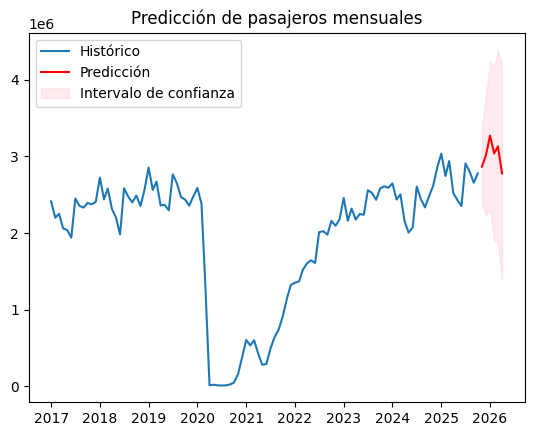

In [24]:
import matplotlib.pyplot as plt

# Serie histórica
plt.plot(serie.index, serie.values, label="Histórico")

# Forecast
forecast = results.get_forecast(steps=6)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.plot(pred_mean.index, pred_mean.values, label="Predicción", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], 
                 color="pink", alpha=0.3, label="Intervalo de confianza")

plt.title("Predicción de pasajeros mensuales")
plt.legend()
plt.show()
